In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib.patches import Ellipse

In [7]:
# Network generation --------------------------------------------------------
random.seed(10)
np.random.seed(10)

n = 1000  # number of nodes
K = 4   # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []

B_list.append(np.array([[0.8, 0.1, 0.5, 0.3],
                        [0.4, 0.6, 0.9, 0.2],
                        [0.7, 0.2, 0.4, 0.8],
                        [0.3, 0.5, 0.6, 0.1]]))

In [8]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [9]:
random.seed(100)
np.random.seed(100)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
A_t = np.random.binomial(n=1, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

# make symmetric by setting the lower triangle equal to the upper triangle
As = np.triu(As) + np.triu(As).T - np.diag(As.diagonal())

As = As.astype(int)
P = np.column_stack(P_list)

In [10]:
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(100)
np.random.seed(100)

M=200
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.binomial(n=1, p=P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    # make symmetric by setting the lower triangle equal to the upper triangle
    As = np.triu(As) + np.triu(As).T - np.diag(As.diagonal())
    
    As = As.astype(float)

    A_true_draws.append(As)

In [11]:
d=4

### Go through all values of $k$ and calculate the area between the curve and the diagonal from the ROC curve plot

In [12]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k_values = []
scores = []

for k in range(2,500):

    p_vals = []
    A_boots_list = []

    for m in A_true_draws:
        p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    # Provided code
    p_hat_list = p_vals
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
    power = roc[power_idx]

    plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
    _ = plt.plot(alphas, roc, color='#228B22')

    # Set title and aspect ratio
    plt.title(f"ROC Curve for 4 Community \n SBM with n={n} nodes, k={k}")
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

    # Calculate the area between ROC and y=x line

    def compute_area_above_below_curve(x, y):
        area_above = 0.0
        area_below = 0.0
        
        for i in range(1, len(x)):
            x0, x1 = x[i - 1], x[i]
            y0, y1 = y[i - 1], y[i]
            line0, line1 = x0, x1  # Since line y = x
            
            if y1 == y0:  # Vertical segment
                if y0 > x0:
                    area_above += (y0 - x0) * (x1 - x0)
                else:
                    area_below += (x0 - y0) * (x1 - x0)
                continue
            
            # Find intersection with y = x
            if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
                if y0 >= x0 and y1 >= x1:
                    area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
                else:
                    area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
            else:
                x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
                if y0 < x0:
                    area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                    area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
                else:
                    area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                    area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
        
        return area_above, area_below

    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)

    # Compute areas
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below

    print(f"Area above the y=x line: {area_above} for k={k}")
    print(f"Area below the y=x line: {area_below} for k={k}")
    print(f"Total area (above and below y=x): {total_area} for k={k}")

    # add to lists
    k_values.append(k)
    scores.append(total_area)

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7fb2f541a280>
Traceback (most recent call last):
  File "/home/uj21900/anaconda3/lib/python3.9/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


In [ ]:
# put scores and x_labels into a dataframe
df = pd.DataFrame({"alpha": x_labels, "score": scores})
df.to_csv("mmsbm_alpha_scores.csv", index=False)

In [12]:
pd.DataFrame(scores).to_csv("4commSBM_k_scores_SYMM.csv")

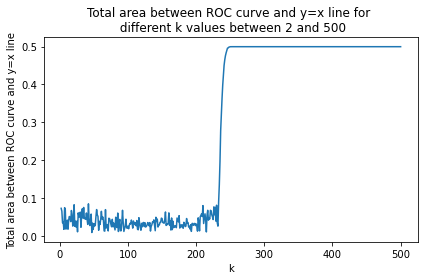

In [23]:
# plot the scores for each k
plt.plot(k_values[0:499], scores[0:499])
plt.xlabel("k")
plt.ylabel("Total area between ROC curve and y=x line")
plt.title("Total area between ROC curve and y=x line for \n different k values between 2 and 500")
#white space
plt.tight_layout()
# white background
plt.gca().set_facecolor('white')
# plt.savefig("4commSBM_k_scores_2_500_SYMM.png")
plt.show()